#Setup

Link google drive

In [1]:
# Link google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install dependencies and run the setup script

In [8]:
# Run the Custom dataset code first to create a config file for a custom dataset
CONFIG_PATH="/content/drive/MyDrive/batch-mask/data/snake-session/config.ini"

# Install requirements, run mask rcnn setup, and load tensorboard
%cd "/content/drive/My Drive/batch-mask/code/Mask_RCNN"
!pip3 install -r requirements.txt
!python3 setup.py install
%load_ext tensorboard
%matplotlib inline

/content/drive/.shortcut-targets-by-id/1q331WUeKFzT8u9hcfbZS4ZLbrbhRB-WR/Snake Masking/code/Mask_RCNN
     |████████████████████████████████| 1.9 MB 5.3 MB/s 
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_lin

Source Repository: https://github.com/akTwelve/Mask_RCNN.git

# Custom Dataset

Creates A Session Folder For Custom Datasets

In [9]:
import os

log_dir="/content/drive/MyDrive/batch-mask/data/sessions/example_session"
if (not os.path.exists(log_dir)):
  os.makedirs(log_dir)

dataset_dir="/content/drive/MyDrive/batch-mask/data/datasets/"

with open(log_dir + "/config.ini", "w") as config_file:
  config_file.write("[DEFAULT]\n")

  config_file.write("TILE_SIZE = 512\n")
  config_file.write("OVERLAP = 100\n")
  config_file.write("LEARNING_RATE = 0.0001\n")
  config_file.write("TRAIN_TO_VAL = 0.9\n")
  config_file.write("NUM_EPOCHS = 20\n")
  config_file.write("TRAINING_STEPS = 450\n")
  config_file.write("VALIDATION_STEPS = 50\n")
  config_file.write("VAL_SAMPLES_PER_IMAGE = 30\n")
  config_file.write("AUGMENT = False\n")
  config_file.write("DISPLAY_TILES = False\n")
  config_file.write("GREY_STD_RADIUS = 16.6085\n")
  config_file.write("CALCULATE_SCALE_BAR = False\n")
  config_file.write("\n")

  config_file.write("[PATHS]\n")
  config_file.write("DIRECTORY : " + log_dir + "\n")
  config_file.write("DATA_SETS : " + dataset_dir + "\n")
  config_file.write("TRAIN_VAL_SETS : %(DATA_SETS)s/train_val_sets\n")
  config_file.write("TRAIN_WEIGHTS : coco\n")
  config_file.write("IMAGE_POOL : all\n")
  config_file.write("TEST_SET : %(DATA_SETS)s/test_set_std\n")
  config_file.write("TEST_WEIGHTS : coco\n")
  if(not os.path.exists(log_dir + "/weights")):
    os.mkdir(log_dir + "/weights")
  config_file.write("SAVE_WEIGHTS : %(DIRECTORY)s/weights\n")
  if(not os.path.exists(log_dir + "/ouput masks splashes")):
    os.mkdir(log_dir + "/ouput masks splashes")
  config_file.write("SAVE_SPLASHES : %(DIRECTORY)s/ouput masks splashes\n")
  if(not os.path.exists(log_dir + "/ouput masks json")):
    os.mkdir(log_dir + "/ouput masks json")
  config_file.write("SAVE_MASKS_JSON : %(DIRECTORY)s/ouput masks json\n")
  if(not os.path.exists(log_dir + "/ouput masks binary")):
    os.mkdir(log_dir + "/ouput masks binary")
  config_file.write("SAVE_MASKS_BINARY : %(DIRECTORY)s/ouput masks binary\n")
  with open(log_dir + "/time_stamps.txt","w+") as time_stamp:
    config_file.write("TIME_STAMP : %(DIRECTORY)s/time_stamps.txt\n")
  config_file.write("META_DATA : None\n")

# Code

Run to compile

In [13]:
############################################################
#  IMPORTS
############################################################
import cv2 as cv2
import numpy as np
import os.path
import sys
import random
import math
import glob
import csv
import matplotlib.pyplot as plt
import json
import os
import configparser
import skimage
from skimage import draw
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sys import exit
from datetime import datetime
from mrcnn.config import Config
from mrcnn import model as modellib, utils
import rawpy

############################################################
#  GLOBAL VARIABLES
############################################################

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

cfg = configparser.ConfigParser()
meta_data = {}
IMAGE_TYPES = ['.jpg', '.JPG', '.png', '.PNG', '.nef', '.NEF']

############################################################
#  CONFIG FILE READER
############################################################

def import_config(file):
  """ Opens config file and assigns it to cfg.
  Opens meta file and assigns it to meta_data
  file: config file path
  """
  global cfg
  if (not os.path.exists(file)):
    print("Can not find " + file)
    print("Double check that the config file exists and that the config path variable (located in the setup section) is correct.")
    exit(1)
  cfg.read(file)
  if(not cfg['DEFAULT']):
    print("DEFAULT is not a section in the config file.")
    print("This sections should contain parameters that can be adjusted for training the nueral network.")
    print("Double check that this section exists in the config file.")
    exit(1)
  if(not cfg['PATHS']):
    print("PATHS is not a section in the config file.")
    print("This sections should contain paths for weight files and dataset.")
    print("Double check that this section exists in the config file.")
    exit(1)
  global meta_data
  if(not (cfg_path('META_DATA') == "None")):
    with open(cfg_path('META_DATA'), 'r') as csv_file:
      csv_reader = csv.reader(csv_file, delimiter=',')
      for row in csv_reader:
        meta_data[row[0]] = row[1:]

def cfg_int(key):
  """ Finds integer from config file
  key: key for the integer value

  Returns integer from config file if key exists. Otherwise returns 0.
  """
  if key in cfg['DEFAULT']:
    return int(cfg['DEFAULT'][key])
  else:
    print("The " + key + "is not in the DEFAULT section of the config file or does not exists.")
    print("Double check that the name of the key is spelled correctly in the config file and that the key exists in the DEFAULT section.")
    exit(1)

def cfg_float(key):
  """ Finds float from config file
  key: key for the float value

  Returns float from config file if key exists. Otherwise returns 0.0.
  """
  if key in cfg['DEFAULT']:
    return float(cfg['DEFAULT'][key])
  else:
    print("The " + key + "is not in the DEFAULT section of the config file or does not exists.")
    print("Double check that the name of the key is spelled correctly in the config file and that the key exists in the DEFAULT section.")
    exit(1)

def cfg_bool(key):
  """ Finds bool from config file
  key: key for the bool value

  Returns bool from config file if key exists. Otherwise returns False.
  """
  if key in cfg['DEFAULT']:
    return (cfg['DEFAULT'][key] == "True")
  else:
    print("The " + key + "is not in the DEFAULT section of the config file or does not exists.")
    print("Double check that the name of the key is spelled correctly in the config file and that the key exists in the DEFAULT section.")
    exit(1)

def cfg_path(key):
  """ Finds path from config file
  key: key for the path

  Returns path from config file if key exists. Otherwise returns empty string.
  """
  if key in cfg['PATHS']:
    return cfg['PATHS'][key]
  else:
    print("The " + key + "is not in the PATHS section of the config file or does not exists.")
    print("Double check that the name of the key is spelled correctly in the config file and that the key exists in the PATHS section.")
    exit(1)

############################################################
#  UTILITY FUNTIONS
############################################################

def read_nef(path):
  """
  Read in nef files using rawpy and imageio
  """
  raw = rawpy.imread(path)
  rgb = raw.postprocess(no_auto_bright=True, use_auto_wb=False, gamma=None)
  return rgb

def display_img(image, cmap=None):
  """ Displays an image in the terminal
  image: RGB image [height, width, 3]
  """
  fig = plt.figure(figsize = (12,12))
  plt.axis(False)
  ax = fig.add_subplot(111)
  ax.imshow(image, cmap)

def preproccess_image(image):
  """ Add gaussian blur to an image using it for training or inference
  image: RGB image [height, width, 3]

  Returns preprocessed image
  """
  image = cv2.GaussianBlur(image, (5, 5), 0)

  return image

def clamp(x, x_min, x_max):
  # clamps the x value based of x_min and x_max
  return max(x_min, min(x_max, x))

def random_brightness(image, low, high):
  """ Randomly adjust the brightness of an image
  low: (float) lowest possible change
  high: (float) highest possible change

  Returns image with the adjusted brighness [height, width, 3]
  """
  value = random.uniform(low, high)
  hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  hsv = np.array(hsv, dtype = np.float64)
  hsv[:,:,1] = hsv[:,:,1]*value
  hsv[:,:,1][hsv[:,:,1]>255]  = 255
  hsv[:,:,2] = hsv[:,:,2]*value 
  hsv[:,:,2][hsv[:,:,2]>255]  = 255
  hsv = np.array(hsv, dtype = np.uint8)
  image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
  return image

def random_color_shift(image, value):
  """ Randomly shifts all color channels by a random value
  value: (float) the random shift ranges from -value to value

  Returns image with the adjusted color shift [height, width, 3]
  """
  value = int(random.uniform(-value, value))
  image = image + value
  image[:,:,:][image[:,:,:]>255]  = 255
  image[:,:,:][image[:,:,:]<0]  = 0
  image = image.astype(np.uint8)
  return image

def augment_image(image):
  """ Augments an image with a random brightness and color shift
  """
  image = random_brightness(image, 0.5, 3)
  image = random_color_shift(image, 60)
  return image

def get_image_path(images_path, label_path):
  """ Images in the snake dataset end with .JPG or .jpg.
  This will automatically return the correct path based on the label path.
  images_path: path to folder containing all images in the dataset
  label_path: path to the corresponding label file

  Returns correct image path
  """
  name = os.path.join(images_path, os.path.basename(label_path)[:-5])
  for image_type in IMAGE_TYPES:
    if os.path.exists(name + image_type):
      return name + image_type
  print("Could not find image path for : " + os.path.basename(label_path)[:-5])
  print("images must be ones of these types: " + image_types)
  exit(1)

def color_splash(image, mask):
  """ Apply color splash effect.
  image: RGB image [height, width, 3]
  mask: instance segmentation mask [height, width, instance count]

  Returns result image.
  """
  # Make a grayscale copy of the image. The grayscale copy still
  # has 3 RGB channels, though.
  gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255 * [0, 0, 1.5]
  # Copy color pixels from the original color image where mask is set
  if mask.shape[-1] > 0:
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    splash = np.where(mask, image, gray).astype(np.uint8)
  else:
    splash = gray.astype(np.uint8)
  return splash

def find_contours(mask):
  """ Returns the contours from a brinary mask. 
  Useful for storing masks in smaller files.
  mask: binray segmentation mask [height, width, 1]

  Returns contours.
  """
  black = np.zeros(mask.shape, np.float32)
  white = np.ones(mask.shape, np.float32) * 255
  new_mask = np.where((np.sum(mask, -1, keepdims=True) >= 1), white, black)
  gray = cv2.cvtColor(new_mask, cv2.COLOR_BGR2GRAY)
  _, threshold = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(threshold.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  return contours

def find_max_contour(contours):
  """ Returns the contour with the largest area from a list of contours. 
  contours: contours returned from the find_countours() function

  Returns max area contour.
  """
  max_cnt = 0
  max_area = 0
  for i in range(len(contours)):
    cnt = contours[i]
    area = cv2.contourArea(cnt)
    if max_area < area:
      max_area = area
      max_cnt = i
  return max_cnt, max_area

def contour_to_roi(cnt):
  """ Converts a contour to the json file format.
  cnt: the contour to be converted.

  Returns roi dictionary.
  """
  roi = {}
  roi['type'] = 'polygon'
  roi['count'] = len(cnt)
  roi['x'] = []
  roi['y'] = []
  for pair in cnt:
    roi['x'].append(int(pair[0][0]))
    roi['y'].append(int(pair[0][1]))
  return roi

def draw_roi_polygon(mask, roi, fill = True):
  """ Draws a polygon on a mask based on the roi
  mask: A bool array of shape [height, width, 1].
  roi: roi dictionary.
  fill: if true, fills the polygon with true, otherwise it fills it with false.
  """
  rr, cc = skimage.draw.polygon(roi['y'], roi['x'], (mask.shape[0], mask.shape[1]))
  mask[rr, cc, 0] = fill

def draw_roi_composite(mask, roi):
  """ Draws a composite roi on a mask.
  This only works for coiled shaped rois like snakes.
  mask: A bool array of shape [height, width, 1].
  roi: roi dictionary.
  """
  if roi['count'] > 0:
    draw_roi_polygon(mask, roi['rois'][-1], fill = True)
    for i in range(roi['count'] - 1):
      draw_roi_polygon(mask, roi['rois'][i], fill = False)

############################################################
#  UTILITY CLASSES
############################################################

class dataitem():

  def __init__(self, label_path, image_path):
    """ Loads the image file
    If a roi file already exists, this will load it.
    Otherwise it creates a new roi dictionary.
    label_path: path to either load or save the roi.
    image_path: path to image.
    """
    self.label_path = label_path
    self.image_path = image_path
    image_type = os.path.basename(image_path).split(".")[-1]
    if image_type == "nef" or image_type == "NEF":
      image = read_nef(image_path)
    else:
      image = skimage.io.imread(image_path)
    self.height, self.width, self.depth = image.shape
    if os.path.exists(label_path):
      with open(label_path,'r') as file:
        read = file.read()
        self.data = json.loads(read)
    else:
      self.data = {}
      self.data['rois'] = []
      self.data['classes'] = []
      self.data['count'] = 0

  def get_mask(self):
    """ Creates a binary mask based on the first composite or polygon roi in the roi dictionary.

    Returns a binary mask [height, width, 1]
    """
    mask = np.zeros((self.height, self.width, 1), dtype=np.bool)
    for i in range(self.data['count']):
      roi = self.data['rois'][i]
      if roi['type'] == 'composite':
        draw_roi_composite(mask, roi)
        return mask
      elif roi['type'] == 'polygon':
        draw_roi_polygon(mask, roi)
        return mask

  def cv2_image(self):
    """ Loads the image as a cv2 image

    Returns an image [height, width, 3]
    """
    return cv2.imread(self.image_path)

  def sk_image(self):
    """ Loads the image as a sk image

    Returns an image [height, width, 3]
    """
    image_type = os.path.basename(self.image_path).split(".")[-1]
    if image_type == "nef" or image_type == "NEF":
      return preproccess_image(read_nef(self.image_path))

    return preproccess_image(skimage.io.imread(self.image_path))
  
  def display_mask(self):
    """ Applies a color splash to the image based on the mask and displays it to the console.

    Returns the color splashed image [height, width, 3]
    """
    output = color_splash(self.sk_image(), self.get_mask())
    display_img(output)
    return output

  def display_scalebar(self):
    """ Applies a line roi to the image based on the second roi in the roi dictionary.
    Displays the image to the console.

    Returns image with the scalebar [height, width, 3]
    """
    output = self.cv2_image()
    for i in range(self.data['count']):
      if("Scale Bar:" in self.data['classes'][i]):
        height, width, depth = output.shape
        roi = self.data['rois'][i]
        name = self.data['classes'][i]
        output = cv2.line(output, (roi['x1'], roi['y1']), (roi['x2'], roi['y2']), (0, 255, 0), 9)
        print(name)
    
        display_img(output)
        return output

    print("Scale bar not found")
    return output

  def set_mask(self, mask):
    """ Updates the first roi in the roi dictionary to be reflective of the mask.
    mask: binary mask [height, width, 1]
    """
    class_name = os.path.basename(self.image_path)
    data_file = os.path.basename(self.label_path)

    if data_file in meta_data:
      class_name = ""
      for i in range(1, len(meta_data[data_file]) - 1):
        class_name += meta_data[data_file][i] + "_"
      class_name += meta_data[data_file][len(meta_data[data_file]) - 1]
    
    class_index = -1
    for i in range(self.data['count']):
      if self.data['classes'][i] == class_name:
        class_index = i

    if(class_index == -1):
      self.data['classes'].append(class_name)
      self.data['rois'].append({})
      self.data['count'] = len(self.data['classes'])
      class_index = self.data['count'] - 1


    contours = find_contours(mask)
    max_cnt, max_area = find_max_contour(contours)

    self.data['rois'][class_index]['type'] = 'composite'
    self.data['rois'][class_index]['count'] = len(contours)
    self.data['rois'][class_index]['rois'] = []
    if(len(contours) > 0):
      for i in range(len(contours)):
        if not i == max_cnt:
          cnt = contours[i]
          roi = contour_to_roi(cnt)
          self.data['rois'][class_index]['rois'].append(contour_to_roi(cnt))

      roi = contour_to_roi(contours[max_cnt])
      self.data['rois'][class_index]['rois'].append(roi)
  
  def calculate_scalebar(self, maxRadius = 550):
    """ Calculates a scalebar by finding the grey color standard 
    using the Hough Circles algorithm.
    Saves the scalebar to the second roi in the roi dictionary.
    maxRadius: (integer) some images require a larger or smaller max radius
    depending on how zoomed in the camera is.
    """
    scale_bar_index = -1
    for i in range(self.data['count']):
      if("Scale Bar:" in self.data['classes'][i]):
        scale_bar_index = i
    
    if scale_bar_index == -1:
      self.data['classes'].append("")
      self.data['rois'].append({})
      self.data['count'] = len(self.data['classes'])
      scale_bar_index = self.data['count'] - 1

    scale = 4
    image = cv2.resize(self.cv2_image(), (int(self.width/scale), int(self.height/scale)))
    output = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # finds possible circles in the image
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 1000, param1 = 650, param2 = 1, minRadius = 15, maxRadius = int(maxRadius/scale))
     
    # if there are no circles detected, in form the user
    if circles is None:
      print("no circle detected")
    else:
      circles = np.round(circles[0, :]).astype("int")

      # x and y are the center of the circle, r is the radius
      x, y, r = circles[0]

      # scale up the coordinates
      x = x*scale
      y = y*scale
      r = r*scale
      GREY_STD_RADIUS = cfg_float('GREY_STD_RADIUS') # radius of circle in mm

      # saves the scale bar to the second roi
      self.data['classes'][1] = ("Scale Bar:" + str(r) + ":" + str(GREY_STD_RADIUS))
      self.data['rois'][1]['type'] = 'line'
      self.data['rois'][1]['x1'] = int(x)
      self.data['rois'][1]['y1'] = int(y)
      self.data['rois'][1]['x2'] = int(x + r)
      self.data['rois'][1]['y2'] = int(y)
    
  def save_data(self):
    """ Saves the current roi dictionary based on the label path
    """
    with open(self.label_path,'w') as file:
      file.write(json.dumps(self.data))

class image_pool_class():
  def __init__(self):
    """ Loads the images and labels for training 
    based on the paths in the config file.
    """
    
    self.subpools = {}
    self.subpools['all'] = {}
    self.subpools['all']['paths'] = []
    self.subpools['all']['train'] = []
    self.subpools['all']['val'] = []

    for root, dirs, files in os.walk(cfg_path('TRAIN_VAL_SETS'), topdown=False):
      if(root != cfg_path('TRAIN_VAL_SETS')):
        subset = os.path.basename(root)
        self.subpools[subset] = {} 
        self.subpools[subset]['paths'] = glob.glob(root + '/*.json')
        self.subpools[subset]['train'], self.subpools[subset]['val'] = train_test_split(self.subpools[subset]['paths'], train_size=cfg_float('TRAIN_TO_VAL'), random_state=0)
        self.subpools['all']['paths'] += self.subpools[subset]['paths']
        self.subpools['all']['train'] += self.subpools[subset]['train']
        self.subpools['all']['val'] += self.subpools[subset]['val']
        

    self.train_pool = self.subpools[cfg_path('IMAGE_POOL')]['train']
    self.val_pool = self.subpools[cfg_path('IMAGE_POOL')]['val']

    self.datum = {}

    for path in self.subpools['all']['paths']:
      self.datum[path] = dataitem(path, get_image_path(os.path.dirname(path), path))

class SnakeConfig(Config):
    """Configuration for training on the snake dataset.
    Derives from the base Config class and overrides some values.
    """

    def __init__(self):
      # Give the configuration a recognizable name
      self.NAME = "snake"

      self.GPU_COUNT = 1
      self.IMAGES_PER_GPU = 1

      # Number of classes (including background)
      self.NUM_CLASSES = 2

      batch_size = self.GPU_COUNT * self.IMAGES_PER_GPU
      self.STEPS_PER_EPOCH = cfg_int('TRAINING_STEPS') // batch_size
      self.VALIDATION_STEPS = cfg_int('VALIDATION_STEPS') // batch_size
      
      self.IMAGE_MIN_DIM = cfg_int('TILE_SIZE')
      self.IMAGE_MAX_DIM = cfg_int('TILE_SIZE')

      # Since there is only one class, we can set min confidence to zero
      self.DETECTION_MIN_CONFIDENCE = 0.0
      self.LEARNING_RATE = cfg_float('LEARNING_RATE')
      Config.__init__(self)



############################################################
#  Dataset
############################################################

class SnakeDataset(utils.Dataset):
    
  def load_snake(self, subset, image_pool):

    """Load a subset of the Snake dataset.
    subset: Subset to load: train or val
    image_pool: image pool to load images and labels from
    """
    self.image_pool = image_pool
    self.subset = subset
    self.displayed = 0
    # Add classes.
    self.add_class("snake", 1, "snake")

    if self.subset == 'val':
      data_paths = image_pool.val_pool
    else:
      data_paths = image_pool.train_pool

    random.seed(0)
    
    for data_path in data_paths:
      data = image_pool.datum[data_path]
      
      if self.subset == 'val':
        for i in range(cfg_int('VAL_SAMPLES_PER_IMAGE')):
          x = random.randint(0, data.width + cfg_int('TILE_SIZE'))
          y = random.randint(0, data.height + cfg_int('TILE_SIZE'))

          self.add_image(
            "snake",
            image_id=os.path.basename(data.image_path) + '_' + str(i),  # use file name as a unique image id
            tile=i, path=data.label_path, x=x, y=y)
      else:
        self.add_image(
          "snake",
          image_id=os.path.basename(data.image_path),  # use file name as a unique image id
          path=data.label_path)

  
  def load_mask(self, image_id):
      """Generate instance masks for an image.
      Returns:
      masks: A bool array of shape [height, width, instance count] with
          one mask per instance.
      class_ids: a 1D array of class IDs of the instance masks.

      Returns the generated mask and class ids.
      """
      # If not a snake dataset image, delegate to parent class.
      image_info = self.image_info[image_id]
      if image_info["source"] != "snake":
        return super(self.__class__, self).load_mask(image_id)

      # Convert polygons to a bitmap mask of shape
      # [height, width, instance_count]
      info = self.image_info[image_id]
      data_path = info['path']
      mask = self.image_pool.datum[data_path].get_mask()
      class_ids = np.ones([mask.shape[-1]], dtype=np.int32)

      # Return mask, and array of class IDs of each instance.
      tile_size = cfg_int('TILE_SIZE')
      mask = np.pad(mask, ((tile_size, tile_size), (tile_size, tile_size), (0, 0)))
      mask = mask[info["y"] : info["y"] + tile_size, info["x"] : info["x"] + tile_size]
      return mask, class_ids

        
  def load_image(self, image_id):
    """Generate an image from the specs of the given image ID.
    Typically this function loads the image from a file, but
    in this case it generates the image on the fly from the
    specs in image_info.

    Returns the generated image.
    """
    info = self.image_info[image_id]
    data = self.image_pool.datum[info['path']]
    image = data.sk_image()
    tile_size = cfg_int('TILE_SIZE')
    image = np.pad(image, ((tile_size, tile_size), (tile_size, tile_size), (0, 0)))
    # randomly choose tile if training
    if self.subset == 'train':
      info["x"] = random.randint(0, data.width + tile_size)
      info["y"] = random.randint(0, data.height + tile_size)
    
    image = image[info["y"] : info["y"] + tile_size, info["x"] : info["x"] + tile_size]
    # augment image if set to true in config file
    if cfg_bool('AUGMENT'):
      if self.subset == 'train' and random.random() > 0.5:
        image = augment_image(image)

    # used for trouble shooting
    if cfg_bool("DISPLAY_TILES"):
      show_image(image_id, image)

    return image

  def image_reference(self, image_id):
    """Return the path of the image."""
    info = self.image_info[image_id]
    if info["source"] == "snake":
      return self.image_pool.datum[info["path"]].image_path
    else:
      super(self.__class__, self).image_reference(image_id)

  def show_image(self, image_id, image):
    """Displays masked image tiles while training for trouble shooting
    image_id: ID to use for the image info.
    image: the image tile itself
    """
    # can only handle outputing a few images. We set the limit to 30 here.
    if self.displayed < 30:
      mask ,_ = self.load_mask(image_id)
      gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255 * [0, 0, 1.5]
      dis_image = np.where(mask, image, gray).astype(np.uint8)
      display_img(dis_image)
      self.displayed += 1

############################################################
#  Model
############################################################
def load_model(weights, logs, mode):
  """ Loads neural network model.
  weights: path to weights file
  logs: path to logs folder
  mode: either "inference" or "training"
  """ 
  config = SnakeConfig()
  config.display()

  model = modellib.MaskRCNN(mode=mode, config=config,
                                model_dir=logs)
  
  # Select weights file to load
  if weights.lower() == "coco":
    weights_path = COCO_WEIGHTS_PATH
    # Download weights file
    if not os.path.exists(weights_path):
      utils.download_trained_weights(weights_path)
  elif weights.lower() == "last":
    # Find last trained weights
    weights_path = model.find_last()
  elif weights.lower() == "imagenet":
    # Start from ImageNet trained weights
    weights_path = model.get_imagenet_weights()
  else:
    weights_path = weights


  # Load weights
  if weights.lower() == "coco":
    # Exclude the last layers because they require a matching
    # number of classes
    model.load_weights(weights_path, by_name=True, exclude=[
      "mrcnn_class_logits", "mrcnn_bbox_fc",
      "mrcnn_bbox", "mrcnn_mask"])
  else:
    model.load_weights(weights_path, by_name=True)
  

  print("Loading weights ", weights_path)

  return config, model

############################################################
#  Training
############################################################

def train(config = ""):
  """ Trains the neural network model based on the specified config file.
  """
  import_config(config)
  weights = cfg_path('TRAIN_WEIGHTS')
  logs = cfg_path('SAVE_WEIGHTS')
  num_epochs = cfg_int('NUM_EPOCHS')
  
  image_pool = image_pool_class()

  config, model = load_model(weights, logs, "training")
  """Train the model."""
  # Training dataset.
  dataset_train = SnakeDataset()
  dataset_train.load_snake('train', image_pool)
  dataset_train.prepare()

  # Validation dataset
  dataset_val = SnakeDataset()
  dataset_val.load_snake('val', image_pool)
  dataset_val.prepare()

  # *** This training schedule is an example. Update to your needs ***
  # Since we're using a very small dataset, and starting from
  # COCO trained weights, we don't need to train too long. Also,
  # no need to train all layers, just the heads should do it.
  print("Training network heads")
  import time
  start_time = time.time()
  model.train(dataset_train, dataset_val,
              learning_rate=config.LEARNING_RATE,
              epochs = num_epochs,
              layers='all')
  print("--- %s seconds ---" % (time.time() - start_time))


############################################################
#  Detection
############################################################

def detect_mask(image, model):
  """ Subdivides the image and runs each 
  subdivision on the neural network model.
  Postprocesses the image by choosing the contour 
  with the largest surface area as the correct masked object.
  """
  overlap = cfg_int('OVERLAP')
  # reference image. Adds a black border around the original image
  ref = np.pad(image, ((overlap, overlap), (overlap, overlap), (0, 0)))
  height, width = ref.shape[:2]

  # mask starts as black
  mask = np.zeros([height,width,3])

  tile_size = cfg_int('TILE_SIZE')
  num_tiles = 0

  row = 0
  while row < height:
    col = 0
    while col < width:
      # start with a black tile
      tile = np.zeros([tile_size,tile_size,3])

      row_min = max(row, 0)
      row_max = min(row + tile_size, height)
      col_min = max(col, 0)
      col_max = min(col + tile_size, width)
      row_start = 0
      row_end = tile_size
      col_start = 0
      col_end = tile_size

      if row < 0:
        row_start = -row
      if row + tile_size > height:
        row_end = height - row
      if col < 0:
        col_start = -col
      if col + tile_size > width:
        col_end = width - col

      tile[row_start:row_end, col_start:col_end] = ref[row_min:row_max, col_min:col_max]
      tile_mask = model.detect([tile], verbose=1)[0]
      tile_mask = (np.sum(tile_mask['masks'], -1, keepdims=True) >= 1)

      tile_row_start = max(overlap, row_start)
      tile_row_end = min(tile_size - overlap, row_end)
      tile_col_start = max(overlap, col_start)
      tile_col_end = min(tile_size - overlap, col_end)

      mask_row_start = (row + overlap)
      mask__row_end = (row + tile_size - overlap)
      mask_col_start = (col + overlap)
      mask_col_end = (col + tile_size - overlap)

      mask[mask_row_start:mask__row_end, mask_col_start:mask_col_end] = tile_mask[tile_row_start:tile_row_end, tile_col_start:tile_col_end]
      num_tiles += 1

      # since we want the tiles to overlap, we increase by tile_size - 2 * overlap instea of just tile_size
      col += tile_size - 2 * overlap
    row += tile_size - 2 * overlap

  print("number of tiles: " + str(num_tiles))

  # remove black border
  mask = mask[overlap:height - overlap, overlap:width - overlap]

  # postprocessing
  contours = find_contours(mask)

  final_mask = skimage.img_as_ubyte(np.zeros(image.shape, np.float32))
  if len(contours) > 0:
    max_cnt, max_area = find_max_contour(contours)
    final_mask = cv2.drawContours(final_mask, [contours[max_cnt]], 0, 255, -1)
  black = np.zeros(mask.shape, np.float32)
  final_mask = np.where(np.invert(np.sum(mask, -1, keepdims=True) >= 1), black, final_mask)

  return final_mask
      

def detect(image_path, model, output_type, resume, scalebar):
  """
  Detects the snake in the image using the detect_mask function.
  image_path: path to the image
  model: Mask rcnn model with loaded weights
  output_type: three output types
    -"splash": applies a blue splash to the background of the image 
      and saves it to the "SAVE_SPLASHES" path in the config file
    -"json": saves the mask to a json roi file to the "SAVE_MASKS_JSON" path in the config file.
      This one also calculates the scale bar and adds it to the json file.
      We used these files for the ImageJ analysis.
      The training labels are also in this format
    -"binary": saves the mask to a csv file with 0's and 1's representing the binary mask.
      This is the most universal output and can be imported easiest into other softwares.
  resume: if True, it will only run if the output file doesn't already exist.
  """
  logs = cfg_path('SAVE_WEIGHTS')
  # Run model detection and generate the color splash effect
  print("Running on {}".format(image_path))
  image_name = os.path.basename(image_path)
  
  binary_path = os.path.join(cfg_path('SAVE_MASKS_BINARY'), image_name[:-4] + '.csv')
  label_path = os.path.join(cfg_path('SAVE_MASKS_JSON'), image_name[:-4] + '.json')
  splash_path = os.path.join(cfg_path('SAVE_SPLASHES'), image_name[:-4] + '.jpg')
  if output_type == 'splash':
    file_name = label_path
  elif output_type == 'json':
    file_name = splash_path
  elif output_type == 'binary':
    file_name = binary_path

  if not os.path.exists(file_name) or not resume:
    data = dataitem(label_path, image_path)
    image = data.sk_image()
    mask = detect_mask(image, model)
    data.set_mask(mask)

    # Save output
    if output_type == 'splash':
      splash = data.display_mask()
      skimage.io.imsave(splash_path, splash)
    elif output_type == 'json':
      if image_name == 'DSC_1705.jpg':
        if scalebar:
          data.calculate_scalebar(maxRadius=600)
        data.save_data()
      else:
        if scalebar:
          data.calculate_scalebar(maxRadius=550)
        data.save_data()
    elif output_type == 'binary':
      with open(binary_path, 'w') as file:
        writer = csv.writer(file)
        for row in range(data.height):
          next_row = []
          for col in range(data.width):
            if mask[row][col][0] > 0:
              next_row.append(1)
            else:
              next_row.append(0)
          writer.writerow(next_row)

def detect_batch(config = "", output_type="splash", resume=True, scalebar=True):
  """ Calls the detect function for an entire folder of images.
  The path to these images are determined by the "TEST_SET" path in the config file.
  config: config file to load
  output_type: three output types
    -"splash": applies a blue splash to the background of the image 
      and saves it to the "SAVE_SPLASHES" path in the config file
    -"json": saves the mask to a json roi file to the "SAVE_MASKS_JSON" path in the config file.
      We used these files for the ImageJ analysis.
      The training labels are also in this format
    -"binary": saves the mask to a csv file with 0's and 1's representing the binary mask.
      This is the most universal output and can be imported easiest into other softwares.
  resume: if True, it will resume a previous session that was either stopped or crashed.
          Otherwise it will start from the first image and overwrite any existing data.
  scalebar: if mode is "json", then it will calculate the scale bar 
            and add it to the json file when this is true.
  """
  import_config(config)
  weights = cfg_path('TEST_WEIGHTS')
  image_folder = cfg_path('TEST_SET')
  logs = cfg_path('SAVE_WEIGHTS')

  config, model = load_model(weights, logs, "inference")

  # Image or video?
  if image_folder:
    for image_type in IMAGE_TYPES:
      image_paths = glob.glob(image_folder + "/*" + image_type)
      # Read image
      for image_path in image_paths:
        detect(image_path, model, output_type, resume, scalebar)
  print("Finished!!!")

############################################################
#  EVALUATION
############################################################

def compare_label_to_inference(model, data):
  """ Calculates the intersection over union and intersection over labeled
  to compare the labeled mask to the infered mask.
  model: Mask RCNN model loaded with weights to use for inference
  data: dataitem that contains the labeled mask
  """
  width = data.width
  height = data.height
  labeled_mask = data.get_mask().reshape(height, width)

  model_mask = detect_mask(data.sk_image(), model)
  black = np.zeros((height, width), np.bool)
  white = np.ones((height, width), np.bool)
  model_mask = np.where((np.sum(model_mask, -1, keepdims=True) >= 1).reshape(height, width), white, black)

  intersection = np.logical_and(model_mask, labeled_mask)
  union = np.logical_or(model_mask, labeled_mask)
  iou = np.sum(intersection) / np.sum(union)
  iol = np.sum(intersection) / np.sum(labeled_mask)
  return iou, iol

# Calculate evalutaion metric
def eval_metric(config):
  """ Calculates the average intersection over union and intersection over labeled
  using the compare_label_to_inference function.
  config: config file to load
  """
  import_config(config)
  weights = cfg_path('TEST_WEIGHTS')
  logs = cfg_path('SAVE_WEIGHTS')
  image_pool = image_pool_class()
  config, model = load_model(weights, logs, "inference")

  ious = {}
  iols = {}

  for subset in image_pool.subpools:
    ious[subset] = []
    iols[subset] = []
    # run for all subpool images
    for data_path in image_pool.subpools[subset]['val']:
      iou, iol = compare_label_to_inference(model, image_pool.datum[data_path])

      ious[subset].append(iou)
      iols[subset].append(iol)

  for subset in image_pool.subpools:
    # output the results to the console
    print("Average " + subset + " IOU: " + str(np.mean(np.array(ious[subset]))))
    print("Average " + subset + " IOL: " + str(np.mean(np.array(iols[subset]))))


############################################################
#  CHECK DATASET
############################################################

def check(images_path, labels_path, start=0, end=50, mode='json'):
  """ Displays the mask and scale bar from the roi json files.
  images_path: path to the folder containing the images.
  labels_path: path to the folder containing the roi json files.
  """
  # Colab ram can only handle checking 50 images at once
  labels = glob.glob(labels_path + "/*.json")[start:end]
  for label in labels:
    if mode == 'json':
      data = dataitem(label, get_image_path(images_path, label))

      data.display_mask()
      data.display_scalebar()
    elif mode == 'binary':
      with open(label, 'r') as file:
        image_type = os.path.basename(get_image_path(images_path, label)).split(".")[-1]
        if image_type == "nef" or image_type == "NEF":
          image = read_nef(get_image_path(images_path, label))
        else:
          image = skimage.io.imread(get_image_path(images_path, label))
        height, width, = image.shape
        # mask starts as black
        mask = np.zeros([height,width,3])
        csv_reader = csv.reader(file, delimiter=',')

        for row in len(csv_reader):
          for col in len(csv_reader[row]):
            if csv_reader[row][col] == 1:
              mask[row][col] = [255, 255, 255]

        image_type = os.path.basename(get_image_path(images_path, label)).split(".")[-1]
        if image_type == "nef" or image_type == "NEF":
          image = read_nef(get_image_path(images_path, label))
        else:
          image = skimage.io.imread(get_image_path(images_path, label))
        display_img(color_splash(image, mask))


# Check Dataset

Check Dataset Command

Can be used for veiwing either a human labeled dataset (the training set) or a nueral network labeled dataset (the inference set). This is useful to make sure a human labeled dataset is being loaded properly or to qualitatively assess a neural network labeled dataset.

In [ ]:
check(images_path="/content/drive/MyDrive/batch-mask/data/datasets/train_val_sets/dorsal_set", labels_path="/content/drive/MyDrive/batch-mask/data/datasets/train_val_sets/dorsal_set", start=0, end=50, mode="json")

#Train

Training from scratch (weights are saved to the specified weights directory int the config file)

In [ ]:
train(config=CONFIG_PATH)

Run to view loss values

In [ ]:
%tensorboard --logdir=("/content/drive/MyDrive/batch-mask/data/sessionsx/all/weights/snake20210712T1704")

# Detect

Detecting Image Command


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  146.00000  float64
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   42.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  146.00000  float64
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   42.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  129.00000  float64
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:   25

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:338: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:145: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Finished!!!


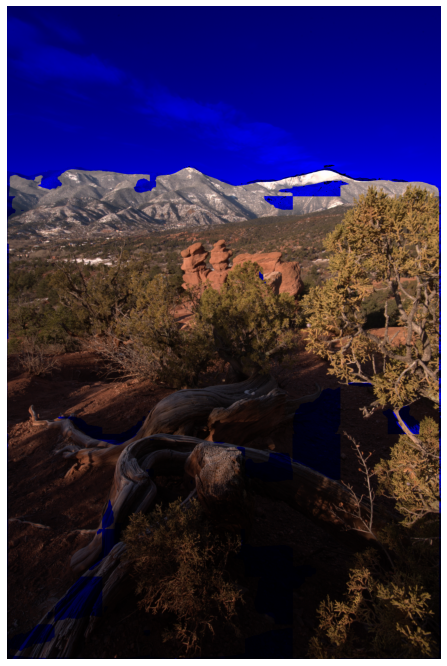

In [14]:
detect_batch(config=CONFIG_PATH, output_type="splash", resume=True)

##Get Model Metric##

In [ ]:
eval_metric(config=CONFIG_PATH)